Saving image.png to image (3).png


/tmp/ipython-input-2202912303.py:43: RuntimeWarning: overflow encountered in power
  term = ((D*D - D0*D0) / (np.maximum(D,eps)*W + eps))**(2*n)


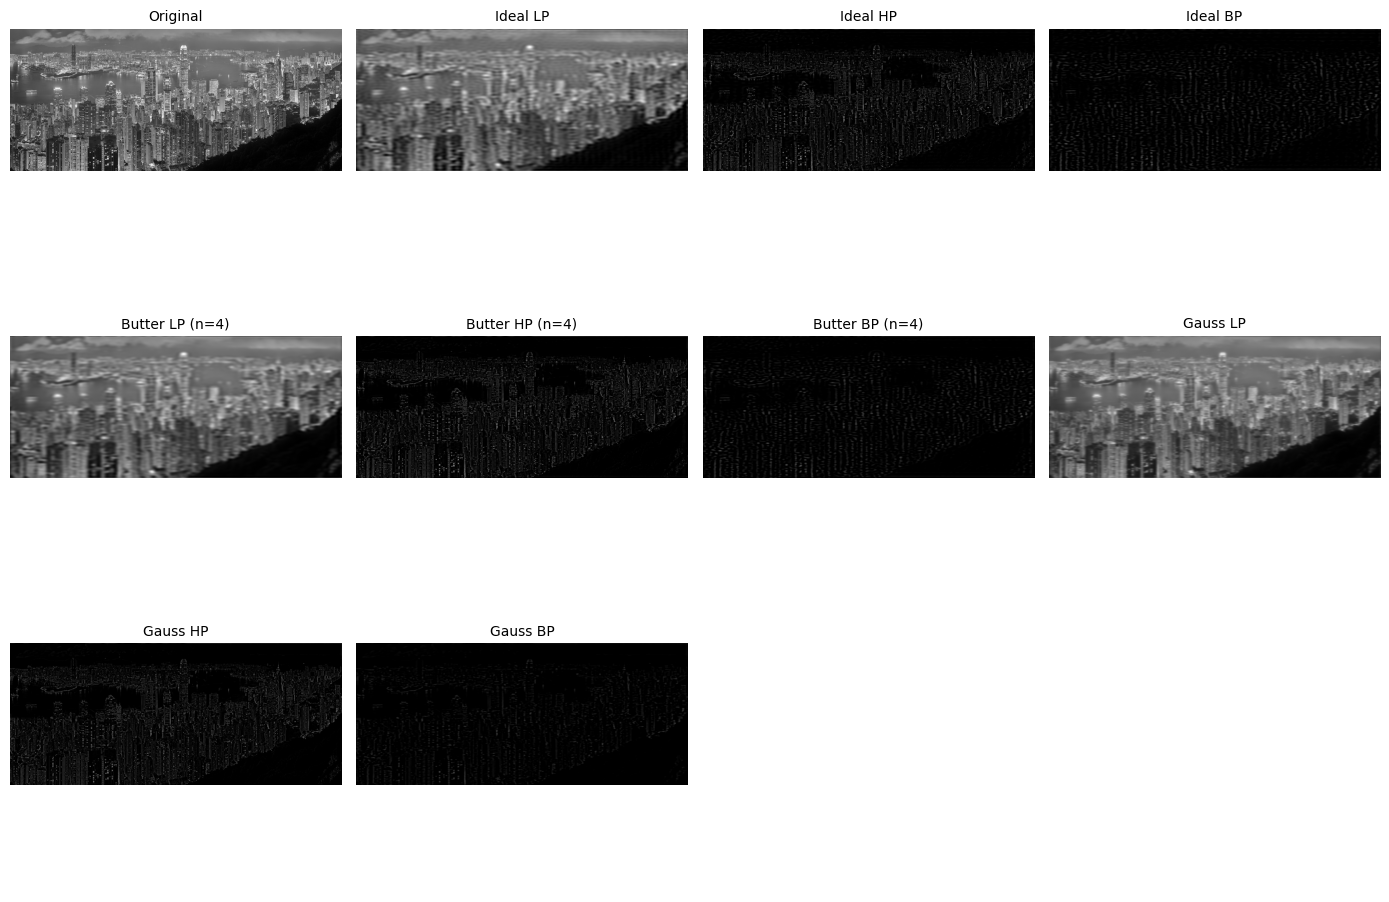

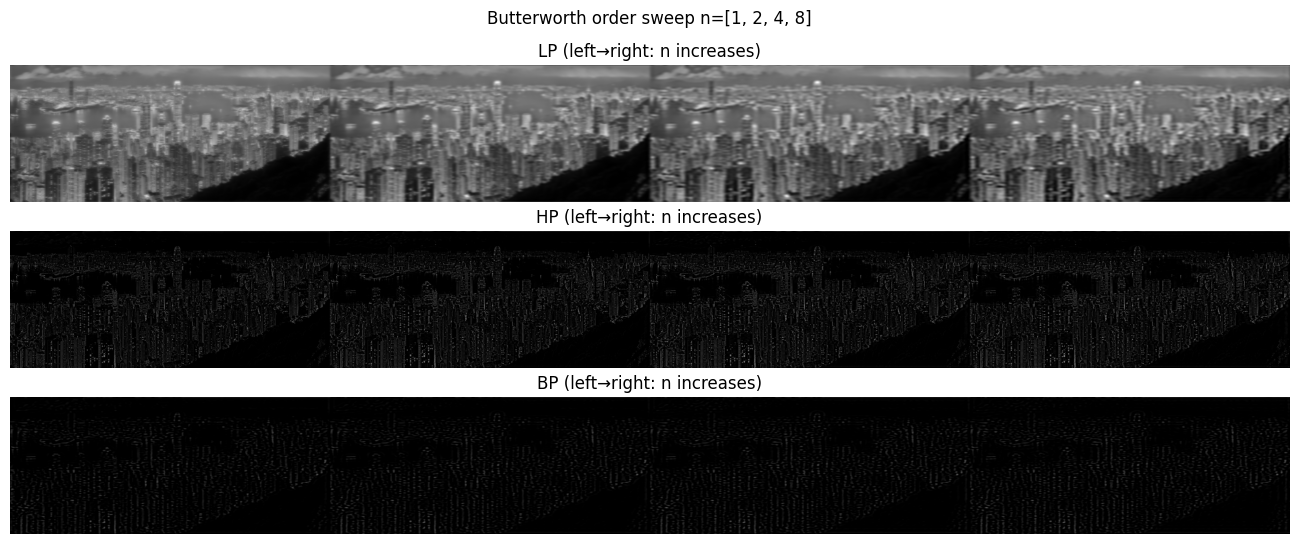

In [4]:


from google.colab import files
uploaded = files.upload()
IMAGE_PATH = next(iter(uploaded))


import cv2
import matplotlib.pyplot as plt
import numpy as np

#IMAGE_PATH = "image.png"
NLIST = [1, 2, 4, 8]
D0_LP = None
D0_HP = None
D0_BP = None
W_BP  = None


def fft2c(x):  return np.fft.fftshift(np.fft.fft2(x))
def ifft2c(X): return np.fft.ifft2(np.fft.ifftshift(X)).real

def radial_distance(h, w):
    u = np.arange(-w//2, w//2)
    v = np.arange(-h//2, h//2)
    U, V = np.meshgrid(u, v)
    return np.sqrt(U**2 + V**2).astype(np.float32)

def apply_H(img01, H):
    return np.clip(ifft2c(fft2c(img01) * H.astype(np.float32)), 0, 1)

# Filters
def ideal_lp(D, D0):
    H = np.zeros_like(D, np.float32); H[D <= D0] = 1.0; return H
def ideal_hp(D, D0): return 1.0 - ideal_lp(D, D0)
def ideal_bp(D, D0, W):
    H = np.zeros_like(D, np.float32); H[np.abs(D - D0) <= (W/2)] = 1.0; return H

def butter_lp(D, D0, n):
    eps = 1e-8
    return 1.0 / (1.0 + (np.maximum(D,eps)/D0)**(2*n))
def butter_hp(D, D0, n): return 1.0 - butter_lp(D, D0, n)
def butter_bp(D, D0, W, n):
    eps = 1e-8
    term = ((D*D - D0*D0) / (np.maximum(D,eps)*W + eps))**(2*n)
    return 1.0 / (1.0 + term)

def gauss_lp(D, D0): return np.exp(-(D*D)/(2*D0*D0))
def gauss_hp(D, D0): return 1.0 - gauss_lp(D, D0)
def gauss_bp(D, D0_low, D0_high):
    return np.clip(gauss_lp(D, D0_high) - gauss_lp(D, D0_low), 0, 1)


bgr = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"Could not read IMAGE_PATH: {IMAGE_PATH}")
if bgr.ndim == 3:
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
else:
    gray = bgr
img01 = gray.astype(np.float32) / 255.0


h, w = img01.shape
D = radial_distance(h, w)
base = min(h, w)
D0_lp = D0_LP or base/10
D0_hp = D0_HP or base/12
D0_bp = D0_BP or base/9
W_bp  = W_BP  or base/12
D0_low, D0_high = max(1, int(D0_bp - W_bp/2)), int(D0_bp + W_bp/2)

n0 = NLIST[len(NLIST)//2]
grid_titles = [
    "Original",
    "Ideal LP", "Ideal HP", "Ideal BP",
    f"Butter LP (n={n0})", f"Butter HP (n={n0})", f"Butter BP (n={n0})",
    "Gauss LP", "Gauss HP", "Gauss BP"
]
grid_images = [
    img01,
    apply_H(img01, ideal_lp(D, D0_lp)),
    apply_H(img01, ideal_hp(D, D0_hp)),
    apply_H(img01, ideal_bp(D, D0_bp, W_bp)),
    apply_H(img01, butter_lp(D, D0_lp, n0)),
    apply_H(img01, butter_hp(D, D0_hp, n0)),
    apply_H(img01, butter_bp(D, D0_bp, W_bp, n0)),
    apply_H(img01, gauss_lp(D, D0_lp)),
    apply_H(img01, gauss_hp(D, D0_hp)),
    apply_H(img01, gauss_bp(D, D0_low, D0_high)),
]

plt.figure(figsize=(14, 10))
for i, (title, im) in enumerate(zip(grid_titles, grid_images), start=1):
    ax = plt.subplot(3, 4, i)
    ax.imshow(im, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

for i in range(len(grid_images)+1, 12+1):
    plt.subplot(3,4,i).axis('off')
plt.tight_layout()


tiles_lp, tiles_hp, tiles_bp = [], [], []
for n in NLIST:
    tiles_lp.append(apply_H(img01, butter_lp(D, D0_lp, n)))
    tiles_hp.append(apply_H(img01, butter_hp(D, D0_hp, n)))
    tiles_bp.append(apply_H(img01, butter_bp(D, D0_bp, W_bp, n)))
mont_lp = np.hstack(tiles_lp)
mont_hp = np.hstack(tiles_hp)
mont_bp = np.hstack(tiles_bp)

plt.figure(figsize=(14, 5.5))
plt.suptitle(f"Butterworth order sweep n={NLIST}", fontsize=12)
ax = plt.subplot(3,1,1)
ax.imshow(mont_lp, cmap='gray', vmin=0, vmax=1); ax.axis('off')
ax.set_title("LP (left→right: n increases)")

ax = plt.subplot(3,1,2)
ax.imshow(mont_hp, cmap='gray', vmin=0, vmax=1)
ax.axis('off')
ax.set_title("HP (left→right: n increases)")

ax = plt.subplot(3,1,3)
ax.imshow(mont_bp, cmap='gray', vmin=0, vmax=1)
ax.axis('off')
ax.set_title("BP (left→right: n increases)")

plt.tight_layout()
plt.show()
